In [1]:
!pip install pandas

In [2]:
!pip install xgboost

In [3]:
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install streamlit


In [4]:
!pip install pandasql


In [5]:
!pip install shap


IMPORTING DEPENDANCIES


In [6]:
## Import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from datetime import datetime, timezone
import seaborn as sns
import datetime as dt
import pandasql as ps
import gc
import pickle
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from matplotlib.pylab import rcParams

#from xgboost import XGBRegressor
# import math
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

LOADING DATASET AND DATA CLEANING


Missing Values Before Imputation:
Age                       0
Quantity                  0
Previous_Donations        0
Average_Income            0
Blood_Utilization_Rate    0
dtype: int64
Gender                   0
Req_Comp                 0
PBloodGroupTested        0
TransfusionIndication    0
Clinical_Diagnosis       0
Region                   0
Healthcare_Facility      0
Population_Density       0
Urgency_Level            0
Seasonal_Health_Trend    0
dtype: int64

Missing Values After Imputation:
Age                       0
Quantity                  0
Previous_Donations        0
Average_Income            0
Blood_Utilization_Rate    0
dtype: int64
Gender                   0
Req_Comp                 0
PBloodGroupTested        0
TransfusionIndication    0
Clinical_Diagnosis       0
Region                   0
Healthcare_Facility      0
Population_Density       0
Urgency_Level            0
Seasonal_Health_Trend    0
dtype: int64
   Patient_ID   Age Gender Req_Comp PBloodGroupTested Trans

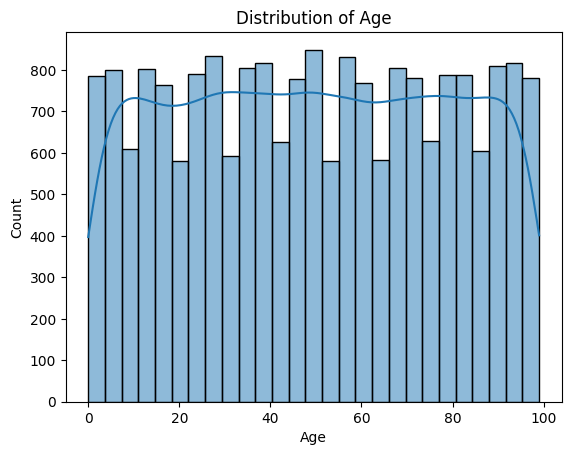

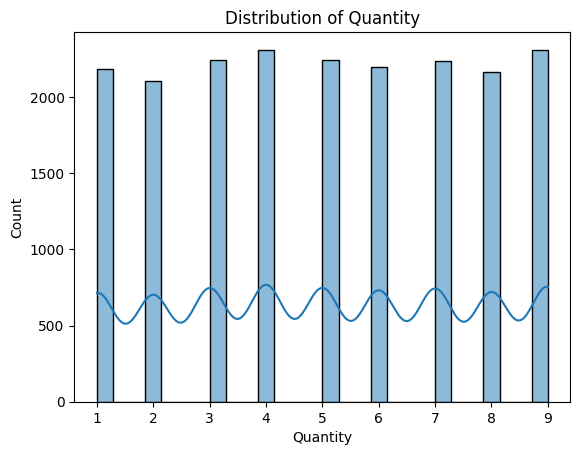

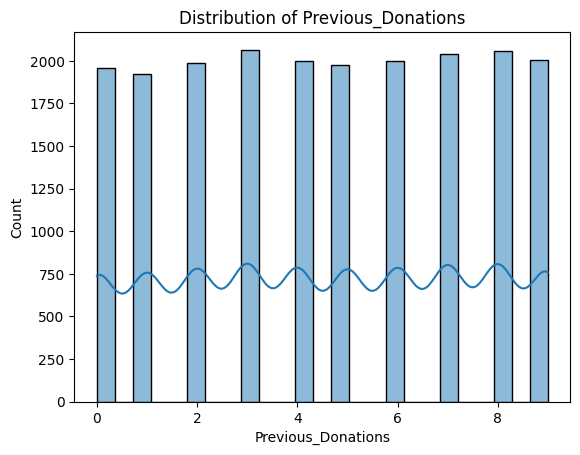

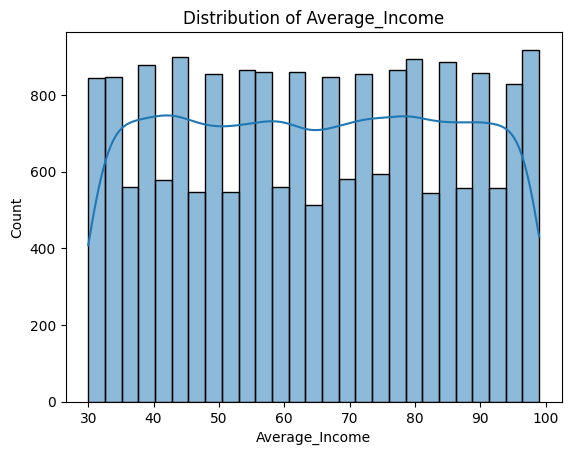

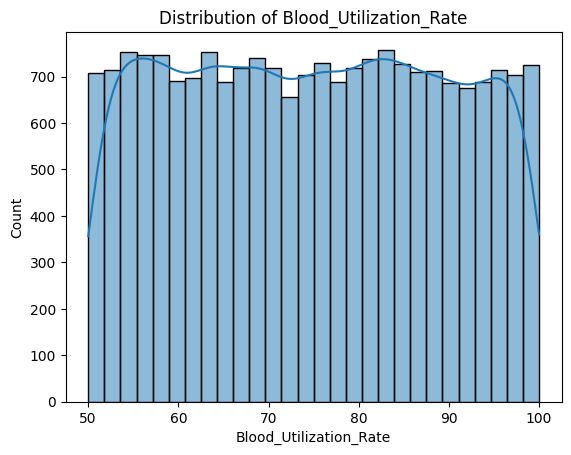

In [7]:
# Loading data
df = pd.read_csv('blood_demand_dataset 2.1.csv')

# Data preprocessing
# Define numerical and categorical columns based on your dataset
numerical_columns = ['Age', 'Quantity', 'Previous_Donations', 'Average_Income', 'Blood_Utilization_Rate']
categorical_columns = ['Gender', 'Req_Comp', 'PBloodGroupTested', 'TransfusionIndication', 
                       'Clinical_Diagnosis', 'Region', 'Healthcare_Facility', 
                       'Population_Density', 'Urgency_Level', 'Seasonal_Health_Trend']

# Check for missing values in numerical and categorical columns
print("\nMissing Values Before Imputation:")
print(df[numerical_columns].isnull().sum())
print(df[categorical_columns].isnull().sum())

# Impute missing values if necessary (based on your dataset's info, it seems there are no missing values)

imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')
df[numerical_columns] = imputer_num.fit_transform(df[numerical_columns])
df[categorical_columns] = imputer_cat.fit_transform(df[categorical_columns])

# Check for missing values after imputation
print("\nMissing Values After Imputation:")
print(df[numerical_columns].isnull().sum())
print(df[categorical_columns].isnull().sum())

# Display the first few rows, column data types
print(df.head())
print(df.info())

# Summary statistics for numerical features
print("\nSummary Statistics for Numerical Features:")
print(df[numerical_columns].describe())

# Summary of categorical data
print("\nCategorical Data Summary:")
for col in categorical_columns:
    print(f"\n{col} Value Counts:")
    print(df[col].value_counts())

# Visualizations for distribution of numerical data
for col in numerical_columns:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


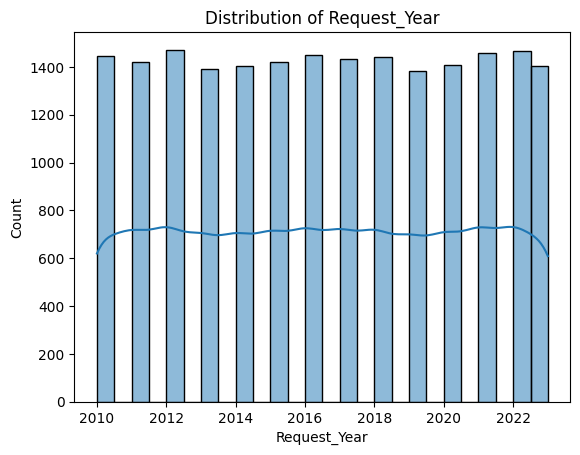

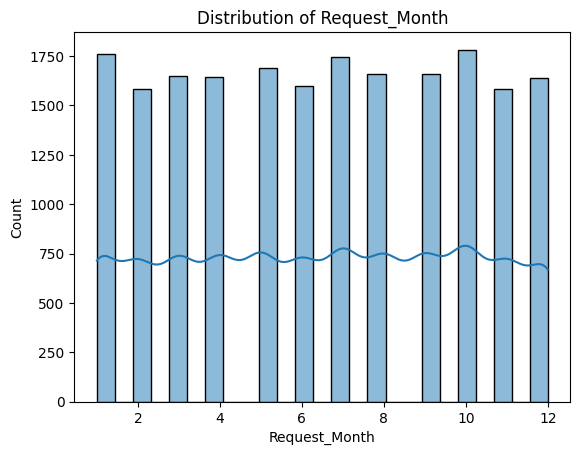

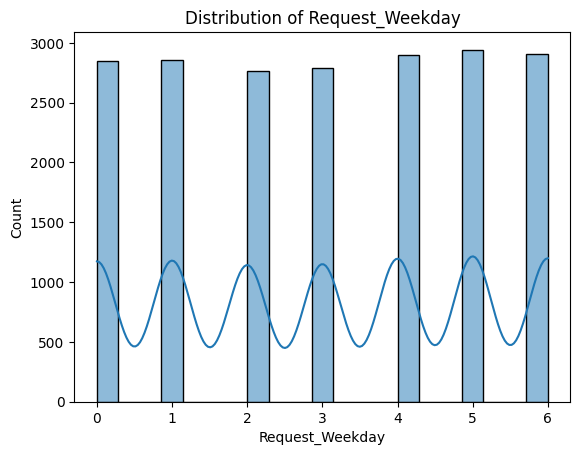

In [8]:
# Convert 'Request_Date' to datetime and create time-related features
df['Request_Date'] = pd.to_datetime(df['Request_Date'])
df['Request_Year'] = df['Request_Date'].dt.year
df['Request_Month'] = df['Request_Date'].dt.month
df['Request_Day'] = df['Request_Date'].dt.day
df['Request_Weekday'] = df['Request_Date'].dt.weekday

# Convert 'DOB' to datetime and calculate age
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
df['Calculated_Age'] = df['Request_Date'].dt.year - df['DOB'].dt.year

# Visualizations for distribution of newly created time-related data
for col in ['Request_Year', 'Request_Month', 'Request_Weekday']:  # Updated to match your dataset
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


DATA CLEANING


In [9]:
import pandas as pd

# Assuming df is your DataFrame after loading the dataset

# Drop any empty line in the file
df.dropna(how='all', inplace=True)

# Handling rows with too many missing values
threshold = len(df.columns) * 0.6  # e.g., rows with more than 40% missing values
df.dropna(thresh=threshold, inplace=True)

# Update the column names based on your dataset
# Drop rows where specific columns are NA
df = df[df['Request_Date'].notna()]  # Replace 'REQDATETIME' with 'Request_Date'
df = df[df['Req_Comp'].notna()]       # Ensure 'Req_Comp' is the correct column name
df = df[df['PBloodGroupTested'].notna()]  # Replace 'PBLOODGROUPTESTED' with 'PBloodGroupTested'

# Convert 'Quantity' to numeric and handle missing or unreasonable values
# Assuming 'QTY' in your original dataset refers to 'Quantity'
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(-1).astype(int)
df = df[(df['Quantity'] > 0) & (df['Quantity'] < 1000)]
df['Quantity'].replace(to_replace=-1, value=df['Quantity'].median(), inplace=True)

# Adjust the date columns and calculations to match your dataset
df['Request_Date'] = pd.to_datetime(df['Request_Date'])
df['Request_Year'] = df['Request_Date'].dt.year
df['Request_Month'] = df['Request_Date'].dt.month
df['Request_Weekday'] = df['Request_Date'].dt.weekday

df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')
df['Calculated_Age'] = df['Request_Date'].dt.year - df['DOB'].dt.year
df['Calculated_Age'] = df['Calculated_Age'].apply(lambda x: x if 0 < x < 100 else np.nan)


C:\Users\ZHAMITTO\AppData\Local\Temp\ipykernel_9868\3737099650.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Quantity'].replace(to_replace=-1, value=df['Quantity'].median(), inplace=True)


In [10]:
df


,Patient_ID,Age,Gender,Req_Comp,PBloodGroupTested,TransfusionIndication,Clinical_Diagnosis,Quantity,Request_Date,DOB,...,Population_Density,Average_Income,Urgency_Level,Seasonal_Health_Trend,Blood_Utilization_Rate,Request_Year,Request_Month,Request_Day,Request_Weekday,Calculated_Age
0,100000,44.0,Male,PRBC,O+,Surgery,Sickle Cell Disease,8,2012-11-08 07:36:00,1968-01-01,...,High,36.0,Routine,Normal,74.920444,2012,11,8,3,44.0
1,100001,47.0,Male,WB,B+,Trauma,Anemia,8,2013-02-03 05:28:00,1966-01-01,...,Low,35.0,Planned Surgery,Normal,97.068558,2013,2,3,6,47.0
2,100002,64.0,Other,RDP,A-,Surgery,Thalassemia,1,2023-07-30 21:26:00,1959-01-01,...,Low,69.0,Emergency,Normal,93.383553,2023,7,30,6,64.0
3,100003,67.0,Other,PRBC,O+,Other,Thalassemia,9,2023-06-01 06:38:00,1956-01-01,...,Low,50.0,Planned Surgery,Normal,91.735473,2023,6,1,3,67.0
4,100004,67.0,Other,PRBC,B-,Surgery,Heart Surgery,9,2013-08-30 18:06:00,1946-01-01,...,Low,88.0,Routine,Normal,65.072711,2013,8,30,4,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,119995,87.0,Male,WB,O-,Trauma,Thalassemia,5,2015-06-15 22:49:00,1928-01-01,...,Low,32.0,Planned Surgery,Normal,84.481499,2015,6,15,0,87.0
19996,119996,82.0,Female,RDP,O-,Anemia,Anemia,2,2021-06-13 01:51:00,1939-01-01,...,High,87.0,Planned Surgery,Normal,56.210601,2021,6,13,6,82.0
19997,119997,15.0,Female,PRBC,A+,Anemia,Trauma,3,2018-12-12 21:21:00,2003-01-01,...,Medium,98.0,Emergency,Increased,83.401528,2018,12,12,2,15.0
19998,119998,40.0,Other,Platelets,B-,Trauma,Anemia,4,2020-08-26 21:15:00,1980-01-01,...,Low,69.0,Routine,Normal,70.159330,2020,8,26,2,40.0


DATA PREPROCESSING

In [11]:
query = """
WITH df1 AS (
  SELECT 
    PBloodGroupTested,
    Req_Comp,
    DATE(Request_Date) AS REQDT,
    SUM(Quantity) AS n_qty_n1d,
    MAX(CASE WHEN CAST(strftime('%w', Request_Date) AS INTEGER) = 0 THEN 1 ELSE 0 END) AS ind_dow0,
    MAX(CASE WHEN CAST(strftime('%w', Request_Date) AS INTEGER) = 1 THEN 1 ELSE 0 END) AS ind_dow1,
    MAX(CASE WHEN CAST(strftime('%w', Request_Date) AS INTEGER) = 2 THEN 1 ELSE 0 END) AS ind_dow2,
    MAX(CASE WHEN CAST(strftime('%w', Request_Date) AS INTEGER) = 3 THEN 1 ELSE 0 END) AS ind_dow3,
    MAX(CASE WHEN CAST(strftime('%w', Request_Date) AS INTEGER) = 4 THEN 1 ELSE 0 END) AS ind_dow4,
    MAX(CASE WHEN CAST(strftime('%w', Request_Date) AS INTEGER) = 5 THEN 1 ELSE 0 END) AS ind_dow5,
    MAX(CASE WHEN CAST(strftime('%w', Request_Date) AS INTEGER) = 6 THEN 1 ELSE 0 END) AS ind_dow6,
    SUM(CASE WHEN Gender = 'Female' THEN Quantity ELSE 0 END) AS n_qty_fem_n1d
  FROM df
  GROUP BY PBloodGroupTested, Req_Comp, REQDT
),
rolling_aggregates AS (
  SELECT
    PBloodGroupTested,
    Req_Comp,
    REQDT,
    SUM(n_qty_n1d) OVER (PARTITION BY PBloodGroupTested, Req_Comp ORDER BY REQDT ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS n_qty_n7d,
    SUM(n_qty_n1d) OVER (PARTITION BY PBloodGroupTested, Req_Comp ORDER BY REQDT ROWS BETWEEN 20 PRECEDING AND CURRENT ROW) AS n_qty_n21d
  FROM df1
)
SELECT 
  df1.PBloodGroupTested,
  df1.Req_Comp,
  df1.REQDT,
  df1.ind_dow0,
  df1.ind_dow1,
  df1.ind_dow2,
  df1.ind_dow3,
  df1.ind_dow4,
  df1.ind_dow5,
  df1.ind_dow6,
  df1.n_qty_n1d,
  rolling_aggregates.n_qty_n7d,
  rolling_aggregates.n_qty_n21d,
  df1.n_qty_fem_n1d
FROM df1
LEFT JOIN rolling_aggregates ON df1.PBloodGroupTested = rolling_aggregates.PBloodGroupTested 
  AND df1.Req_Comp = rolling_aggregates.Req_Comp 
  AND df1.REQDT = rolling_aggregates.REQDT
"""

df_f = ps.sqldf(query, locals())


In [12]:
# Convert 'REQDT' to datetime format explicitly and create a new column for it
df_f['REQDT_DTM'] = pd.to_datetime(df_f['REQDT'])

# Mark holidays using the newly created datetime column 'REQDT_DTM'
holidays = ['2023-01-26', '2023-08-15', '2023-10-02']
df_f['ind_holiday'] = df_f['REQDT_DTM'].dt.strftime('%Y-%m-%d').isin(holidays).astype(int)

# Continue with the rest of your operations using 'df_f' or its copy 'df_final'
df_final = df_f.copy()  # Create a copy for further modifications if necessary

# Generate rolling averages and additional features, ensuring to use 'REQDT_DTM' for datetime-based operations
df_final['rolling_avg_7d'] = df_final.groupby(['PBloodGroupTested', 'Req_Comp'])['n_qty_n1d'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_final['rolling_avg_14d'] = df_final.groupby(['PBloodGroupTested', 'Req_Comp'])['n_qty_n1d'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())

# Add month and day_of_week features based on the 'REQDT_DTM' column
df_final['month'] = df_final['REQDT_DTM'].dt.month
df_final['day_of_week'] = df_final['REQDT_DTM'].dt.dayofweek

# Remove incomplete time periods and specific years if necessary, using 'REQDT_DTM' for any date filtering
df_final = df_final[(df_final['REQDT_DTM'] < "2022-02-10") & (df_final['REQDT_DTM'] >= "2018-06-01")]
df_final = df_final[(df_final['REQDT_DTM'] < "2019-03-15") | (df_final['REQDT_DTM'] >= "2020-11-15")].copy()

# Now your DataFrame 'df_final' should be ready without errors
print("\nFinal DataFrame info:")
print(df_final.info())



Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 2730 entries, 329 to 18672
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   PBloodGroupTested  2730 non-null   object        
 1   Req_Comp           2730 non-null   object        
 2   REQDT              2730 non-null   object        
 3   ind_dow0           2730 non-null   int64         
 4   ind_dow1           2730 non-null   int64         
 5   ind_dow2           2730 non-null   int64         
 6   ind_dow3           2730 non-null   int64         
 7   ind_dow4           2730 non-null   int64         
 8   ind_dow5           2730 non-null   int64         
 9   ind_dow6           2730 non-null   int64         
 10  n_qty_n1d          2730 non-null   int64         
 11  n_qty_n7d          2730 non-null   int64         
 12  n_qty_n21d         2730 non-null   int64         
 13  n_qty_fem_n1d      2730 non-null   int64  

In [13]:
df_final[df_final['REQDT']>="2021-04-01"].describe()

,ind_dow0,ind_dow1,ind_dow2,ind_dow3,ind_dow4,ind_dow5,ind_dow6,n_qty_n1d,n_qty_n7d,n_qty_n21d,n_qty_fem_n1d,REQDT_DTM,ind_holiday,rolling_avg_7d,rolling_avg_14d,month,day_of_week
count,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1159.00000,1159,1159.0,1159.000000,1159.000000,1159.000000,1159.000000
mean,0.146678,0.138913,0.146678,0.144953,0.126833,0.135462,0.160483,5.378775,37.706644,112.340811,1.85591,2021-09-04 11:33:17.238999040,0.0,5.386663,5.369592,7.031924,3.041415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,66.000000,0.00000,2021-04-01 00:00:00,0.0,1.857143,2.928571,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,32.000000,101.000000,0.00000,2021-06-14 12:00:00,0.0,4.571429,4.785714,5.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,38.000000,112.000000,0.00000,2021-09-04 00:00:00,0.0,5.428571,5.357143,7.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,42.000000,122.000000,3.00000,2021-11-24 00:00:00,0.0,6.000000,5.928571,10.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,65.000000,158.000000,16.00000,2022-02-09 00:00:00,0.0,9.285714,8.214286,12.000000,6.000000
std,0.353938,0.346005,0.353938,0.352205,0.332930,0.342364,0.367212,3.061364,8.271946,15.548753,3.01850,NaN,0.0,1.181707,0.881028,3.346926,2.020194


In [14]:
df_final.columns

Index(['PBloodGroupTested', 'Req_Comp', 'REQDT', 'ind_dow0', 'ind_dow1',
       'ind_dow2', 'ind_dow3', 'ind_dow4', 'ind_dow5', 'ind_dow6', 'n_qty_n1d',
       'n_qty_n7d', 'n_qty_n21d', 'n_qty_fem_n1d', 'REQDT_DTM', 'ind_holiday',
       'rolling_avg_7d', 'rolling_avg_14d', 'month', 'day_of_week'],
      dtype='object')

In [15]:
# Display descriptive statistics for df_final for dates on or after April 1, 2021
print("Descriptive Statistics for df_final from April 1, 2021:")
print(df_final[df_final['REQDT'] >= "2021-04-01"].describe())

# Display descriptive statistics for the entire df DataFrame
print("\nDescriptive Statistics for the entire df DataFrame:")
print(df.describe())


Descriptive Statistics for df_final from April 1, 2021:
          ind_dow0     ind_dow1     ind_dow2     ind_dow3     ind_dow4  \
count  1159.000000  1159.000000  1159.000000  1159.000000  1159.000000   
mean      0.146678     0.138913     0.146678     0.144953     0.126833   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   
std       0.353938     0.346005     0.353938     0.352205     0.332930   

          ind_dow5     ind_dow6    n_qty_n1d    n_qty_n7d   n_qty_n21d  \
count  1159.000000  1159.000000  1159.000000  1159.000000  1159.000000   
mean      0.135462     0.160483     5.378775    37.706644   112.340811   
min       0.000000     0.000000     1.000000    13.0000

In [16]:
# Display the column names of df_final
print("Columns in df_final:")
print(df_final.columns)

# Display the column names of df
print("\nColumns in df:")
print(df.columns)


Columns in df_final:
Index(['PBloodGroupTested', 'Req_Comp', 'REQDT', 'ind_dow0', 'ind_dow1',
       'ind_dow2', 'ind_dow3', 'ind_dow4', 'ind_dow5', 'ind_dow6', 'n_qty_n1d',
       'n_qty_n7d', 'n_qty_n21d', 'n_qty_fem_n1d', 'REQDT_DTM', 'ind_holiday',
       'rolling_avg_7d', 'rolling_avg_14d', 'month', 'day_of_week'],
      dtype='object')

Columns in df:
Index(['Patient_ID', 'Age', 'Gender', 'Req_Comp', 'PBloodGroupTested',
       'TransfusionIndication', 'Clinical_Diagnosis', 'Quantity',
       'Request_Date', 'DOB', 'Region', 'Previous_Donations',
       'Healthcare_Facility', 'Population_Density', 'Average_Income',
       'Urgency_Level', 'Seasonal_Health_Trend', 'Blood_Utilization_Rate',
       'Request_Year', 'Request_Month', 'Request_Day', 'Request_Weekday',
       'Calculated_Age'],
      dtype='object')


MODELS

c:\Users\ZHAMITTO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


R-squared: 0.9929141979551841
Root Mean Squared Error (RMSE): 0.2299105863816401

Total actual demand for PRBC, O+ in test set: 249
Total predicted demand for PRBC, O+ in test set: 247.7829132080078
Actual O+ demand as a percentage of total demand: 1.69%
Predicted O+ demand as a percentage of total demand: 1.69%
Model saved to xgboost_model_1d.pkl


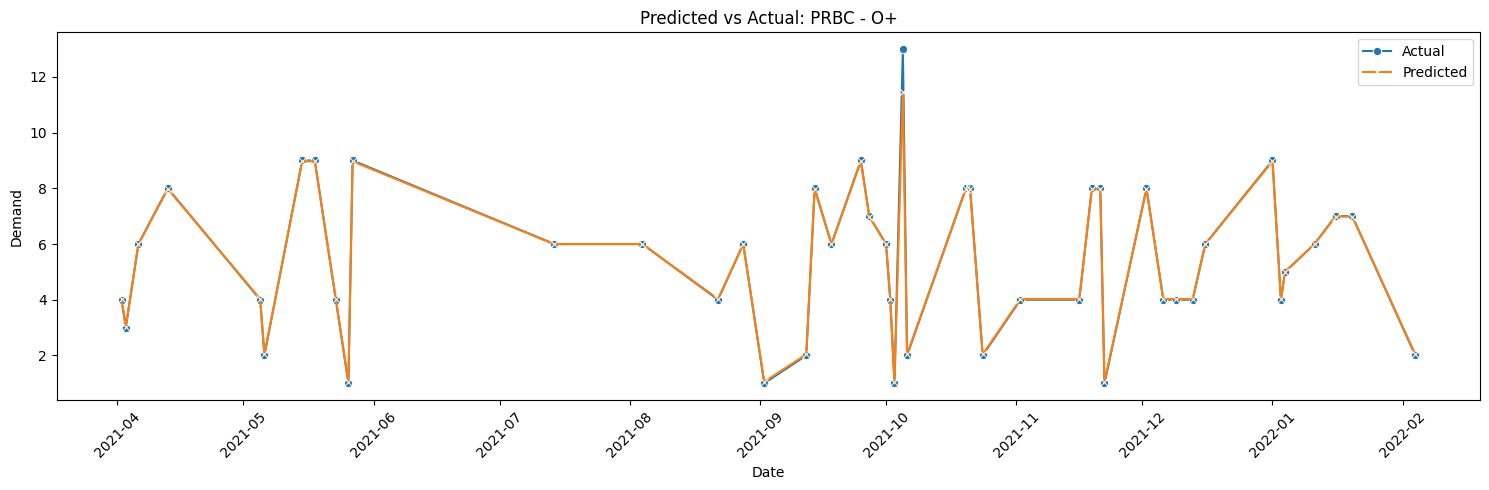

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import pickle  # For saving the model

# Assuming df_final is already defined in your notebook/environment
def my_model_1d(df_final, bc, bg):
    df_model = df_final[(df_final["Req_Comp"] == bc) & (df_final["PBloodGroupTested"] == bg)]

    features = ['n_qty_n1d', 'ind_dow0', 'ind_dow1', 'ind_dow2', 'ind_dow3', 'ind_dow4', 'ind_dow5', 'ind_dow6',
                'n_qty_fem_n1d', 'n_qty_n7d', 'n_qty_n21d', 'ind_holiday']
    label = 'n_qty_n1d'

    train_df = df_model[df_model['REQDT_DTM'] < "2021-04-01"]
    test_df = df_model[df_model['REQDT_DTM'] >= "2021-04-01"]

    X_train, y_train = train_df[features], train_df[label]
    X_test, y_test = test_df[features], test_df[label]

    model = XGBRegressor(n_estimators=500, learning_rate=0.01)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric='mae', verbose=False)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"R-squared: {r2}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Calculate the total demand for all types for the percentage calculation
    total_demand_all_types = df_final['n_qty_n1d'].sum()  # Make sure this aligns with your dataset structure

    total_actual_demand = y_test.sum()
    total_predicted_demand = y_pred.sum()
    percentage_Oplus_of_total_actual = (total_actual_demand / total_demand_all_types) * 100
    percentage_Oplus_of_total_predicted = (total_predicted_demand / total_demand_all_types) * 100

    print(f"\nTotal actual demand for {bc}, {bg} in test set: {total_actual_demand}")
    print(f"Total predicted demand for {bc}, {bg} in test set: {total_predicted_demand}")
    print(f"Actual O+ demand as a percentage of total demand: {percentage_Oplus_of_total_actual:.2f}%")
    print(f"Predicted O+ demand as a percentage of total demand: {percentage_Oplus_of_total_predicted:.2f}%")

    # Save the trained model to a file
    model_filename = 'xgboost_model_1d.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {model_filename}")

    # Visualizations
    # Visualization of actual vs predicted demand
    plt.figure(figsize=(15, 5))
    sns.lineplot(data=test_df, x='REQDT_DTM', y=y_test, label="Actual", marker="o")
    sns.lineplot(data=test_df, x='REQDT_DTM', y=y_pred, label="Predicted", marker="x")
    plt.xticks(rotation=45)
    plt.title(f"Predicted vs Actual: {bc} - {bg}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred, X_test, r2, rmse, model

# Assuming df_final is defined and contains the necessary columns
bc = 'PRBC'
bg = 'O+'
y_pred, X_test, r2, rmse, model = my_model_1d(df_final, bc, bg)


[0]	validation_0-rmse:4.83852
[1]	validation_0-rmse:4.60480
[2]	validation_0-rmse:4.39173
[3]	validation_0-rmse:4.15445
[4]	validation_0-rmse:3.95734
[5]	validation_0-rmse:3.76633
[6]	validation_0-rmse:3.72686
[7]	validation_0-rmse:3.61731
[8]	validation_0-rmse:3.43385
[9]	validation_0-rmse:3.25345
[10]	validation_0-rmse:3.11105
[11]	validation_0-rmse:2.94032
[12]	validation_0-rmse:2.80195
[13]	validation_0-rmse:2.66092
[14]	validation_0-rmse:2.63558
[15]	validation_0-rmse:2.53016
[16]	validation_0-rmse:2.42199
[17]	validation_0-rmse:2.37558
[18]	validation_0-rmse:2.37126
[19]	validation_0-rmse:2.26919
[20]	validation_0-rmse:2.18536
[21]	validation_0-rmse:2.10718
[22]	validation_0-rmse:2.08960
[23]	validation_0-rmse:1.99541
[24]	validation_0-rmse:1.96477
[25]	validation_0-rmse:1.89389
[26]	validation_0-rmse:1.82553
[27]	validation_0-rmse:1.75896
[28]	validation_0-rmse:1.69581
[29]	validation_0-rmse:1.63109
[30]	validation_0-rmse:1.57616
[31]	validation_0-rmse:1.51756
[32]	validation_0-

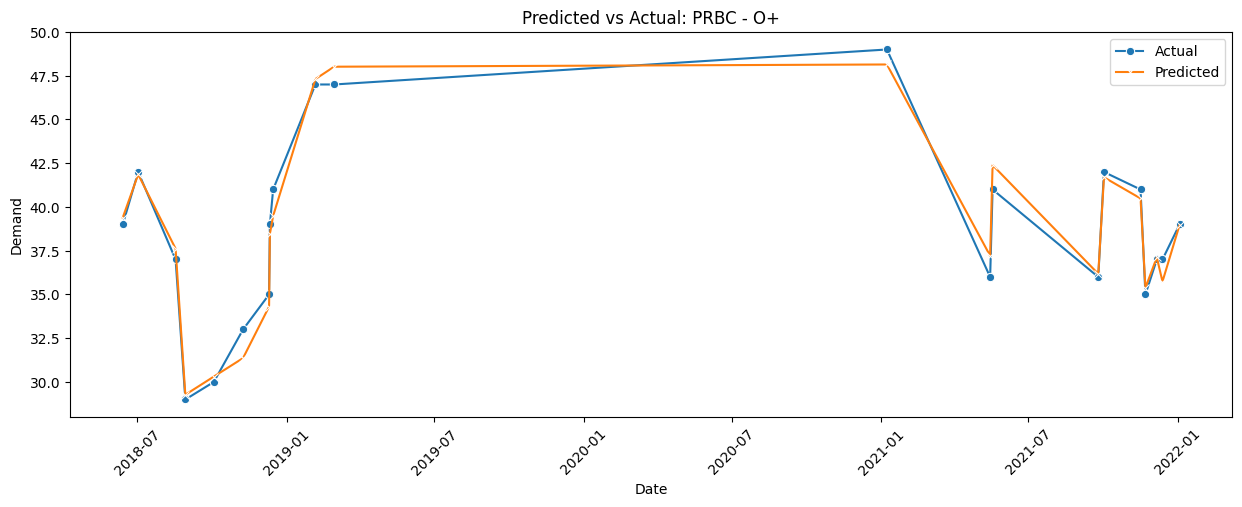

Model saved to model_7d.pkl.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import pickle  # For saving the model

def my_model_7d(df_final, bc, bg):
    # Assuming 'n_qty_n21d' is in your dataset, calculate total demand for all types
    total_demand_all_types = df_final['n_qty_n7d'].sum()

    # Filter the DataFrame for the specific blood component and group
    df_model = df_final[(df_final['Req_Comp'] == bc) & (df_final['PBloodGroupTested'] == bg)].copy()
    
    # Ensure 'REQDT' is a datetime column for potential feature engineering
    df_model['REQDT'] = pd.to_datetime(df_model['REQDT'])
    
    # Defining initial features as specified
    features = ['n_qty_n1d', 'ind_dow0', 'ind_dow1', 'ind_dow2', 'ind_dow3', 'ind_dow4', 'ind_dow5', 'ind_dow6',
                'n_qty_n7d', 'n_qty_n21d', 'n_qty_fem_n1d', 'ind_holiday']
    label = 'n_qty_n7d'
    # Ensure all features are present and correctly engineered in df_model before this step
    X_train, X_test, y_train, y_test = train_test_split(df_model[features], df_model['n_qty_n7d'], test_size=0.2, random_state=42)
    
    # Training the XGBRegressor model
    model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror')
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    
    y_pred = model.predict(X_test)
    
    # Calculating and displaying metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'R2 score: {r2}, RMSE: {rmse}')
    
    # Calculate and display the demanded percentages
    total_actual_demand = y_test.sum()
    total_predicted_demand = y_pred.sum()
    percentage_Oplus_of_total_actual = (total_actual_demand / total_demand_all_types) * 100
    percentage_Oplus_of_total_predicted = (total_predicted_demand / total_demand_all_types) * 100
    
    print(f"\nTotal actual demand for {bc}, {bg} in test set: {total_actual_demand}")
    print(f"Total predicted demand for {bc}, {bg} in test set: {total_predicted_demand}")
    print(f"Actual O+ demand as a percentage of total demand: {percentage_Oplus_of_total_actual:.2f}%")
    print(f"Predicted O+ demand as a percentage of total demand: {percentage_Oplus_of_total_predicted:.2f}%")

    # Visualization
    plt.figure(figsize=(15, 5))
    sns.lineplot(data=df_model.loc[X_test.index], x='REQDT', y=y_test, label="Actual", marker="o")
    sns.lineplot(data=df_model.loc[X_test.index], x='REQDT', y=y_pred, label="Predicted", marker="x")
    plt.xticks(rotation=45)
    plt.title(f"Predicted vs Actual: {bc} - {bg}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.show()

    # Save the trained model to a pickle file
    model_filename = 'model_7d.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    
    print(f"Model saved to {model_filename}.")

    return model, X_train, X_test, y_train, y_test, y_pred

# Example usage
bc = 'PRBC'  # Your specific blood component
bg = 'O+'    # Your specific blood group
# Assuming df_final is prepared with necessary features
model, X_train, X_test, y_train, y_test, y_pred = my_model_7d(df_final, bc, bg)


[0]	validation_0-rmse:12.33382
[1]	validation_0-rmse:12.00240
[2]	validation_0-rmse:11.76409
[3]	validation_0-rmse:11.57054
[4]	validation_0-rmse:11.36434
[5]	validation_0-rmse:11.07787
[6]	validation_0-rmse:10.87187
[7]	validation_0-rmse:10.71425
[8]	validation_0-rmse:10.49447
[9]	validation_0-rmse:10.30664
[10]	validation_0-rmse:10.14299
[11]	validation_0-rmse:9.99046
[12]	validation_0-rmse:9.83309
[13]	validation_0-rmse:9.70048
[14]	validation_0-rmse:9.54339
[15]	validation_0-rmse:9.40210
[16]	validation_0-rmse:9.31522
[17]	validation_0-rmse:9.07361
[18]	validation_0-rmse:8.94021
[19]	validation_0-rmse:8.69895
[20]	validation_0-rmse:8.67345
[21]	validation_0-rmse:8.58127
[22]	validation_0-rmse:8.44664
[23]	validation_0-rmse:8.33500
[24]	validation_0-rmse:8.19336
[25]	validation_0-rmse:8.10985
[26]	validation_0-rmse:7.93851
[27]	validation_0-rmse:7.88650
[28]	validation_0-rmse:7.73414
[29]	validation_0-rmse:7.66842
[30]	validation_0-rmse:7.57602
[31]	validation_0-rmse:7.48898
[32]	va

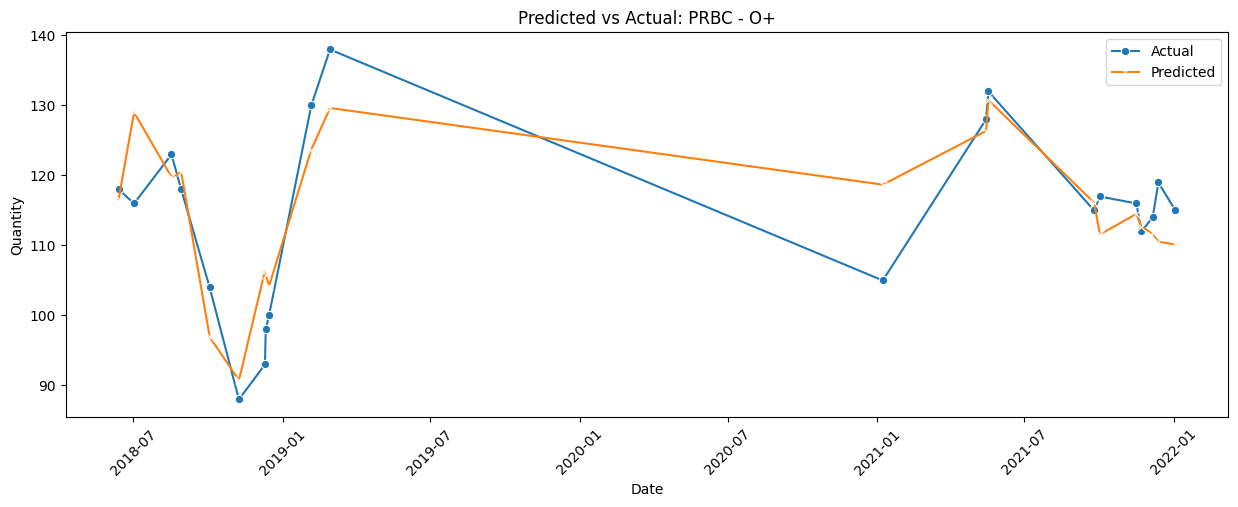

Model saved to model_21d.pkl.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import pickle  # For saving the model

def my_model_21d(df_final, bc, bg):
    # Calculate the total demand for all blood types and components in the dataset
    total_demand_all_types = df_final['n_qty_n21d'].sum()

    # Filter the DataFrame for the specific blood component and group
    df_model = df_final[(df_final['Req_Comp'] == bc) & (df_final['PBloodGroupTested'] == bg)].copy()
    
    # Ensure 'REQDT' is a datetime column
    df_model['REQDT'] = pd.to_datetime(df_model['REQDT'])
    
    # Generating rolling averages and other features
    df_model['rolling_avg_7d'] = df_model.groupby(['PBloodGroupTested', 'Req_Comp'])['n_qty_n1d'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
    df_model['rolling_avg_14d'] = df_model.groupby(['PBloodGroupTested', 'Req_Comp'])['n_qty_n1d'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
    df_model['month'] = df_model['REQDT'].dt.month
    df_model['day_of_week'] = df_model['REQDT'].dt.dayofweek
    df_model['ind_holiday'] = df_model['REQDT'].dt.strftime('%Y-%m-%d').isin(['2023-01-26', '2023-08-15', '2023-10-02']).astype(int)

    # Preparing features and target for the model
    features = ['rolling_avg_7d', 'rolling_avg_14d', 'month', 'day_of_week', 'ind_holiday']
    target = 'n_qty_n21d'
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_model[features], df_model[target], test_size=0.2, random_state=42)
    
    # Training the XGBRegressor model
    model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, objective='reg:squarederror')
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    
    # Making predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculating and displaying metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'R2 score: {r2}, RMSE: {rmse}')
    
    # Calculate and display the demanded percentages
    total_actual_demand = y_test.sum()
    total_predicted_demand = y_pred.sum()
    percentage_Oplus_of_total_actual = (total_actual_demand / total_demand_all_types) * 100
    percentage_Oplus_of_total_predicted = (total_predicted_demand / total_demand_all_types) * 100
    
    print(f"\nTotal actual demand for {bc}, {bg} in test set: {total_actual_demand}")
    print(f"Total predicted demand for {bc}, {bg} in test set: {total_predicted_demand}")
    print(f"Actual O+ demand as a percentage of total demand: {percentage_Oplus_of_total_actual:.2f}%")
    print(f"Predicted O+ demand as a percentage of total demand: {percentage_Oplus_of_total_predicted:.2f}%")

    # Visualization of actual vs predicted demand
    plt.figure(figsize=(15, 5))
    sns.lineplot(x=df_model.loc[X_test.index, 'REQDT'], y=y_test, label="Actual", marker="o")
    sns.lineplot(x=df_model.loc[X_test.index, 'REQDT'], y=y_pred, label="Predicted", marker="x")
    plt.xticks(rotation=45)
    plt.title(f"Predicted vs Actual: {bc} - {bg}")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.show()

    # Save the trained model to a pickle file
    model_filename = 'model_21d.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    
    print(f"Model saved to {model_filename}.")
    
    return model, X_train, X_test, y_train, y_test, y_pred

# Example usage, assuming df_final is your DataFrame loaded with necessary data
bc = 'PRBC'  # Specify your blood component
bg = 'O+'    # Specify your blood group
model, X_train, X_test, y_train, y_test, y_pred = my_model_21d(df_final, bc, bg)


In [20]:
df_final

,PBloodGroupTested,Req_Comp,REQDT,ind_dow0,ind_dow1,ind_dow2,ind_dow3,ind_dow4,ind_dow5,ind_dow6,n_qty_n1d,n_qty_n7d,n_qty_n21d,n_qty_fem_n1d,REQDT_DTM,ind_holiday,rolling_avg_7d,rolling_avg_14d,month,day_of_week
329,A+,PRBC,2018-06-27,0,0,0,1,0,0,0,4,46,110,4,2018-06-27,0,6.571429,5.285714,6,2
330,A+,PRBC,2018-06-28,0,0,0,0,1,0,0,1,42,107,0,2018-06-28,0,6.000000,5.214286,6,3
331,A+,PRBC,2018-07-05,0,0,0,0,1,0,0,8,44,111,8,2018-07-05,0,6.285714,5.285714,7,3
332,A+,PRBC,2018-07-18,0,0,0,1,0,0,0,8,44,113,8,2018-07-18,0,6.285714,5.785714,7,2
333,A+,PRBC,2018-07-22,1,0,0,0,0,0,0,8,39,118,8,2018-07-22,0,5.571429,6.000000,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18668,O-,WB,2022-01-13,0,0,0,0,1,0,0,5,34,110,5,2022-01-13,0,4.857143,5.714286,1,3
18669,O-,WB,2022-01-18,0,0,1,0,0,0,0,6,36,107,6,2022-01-18,0,5.142857,5.642857,1,1
18670,O-,WB,2022-01-20,0,0,0,0,1,0,0,9,43,114,9,2022-01-20,0,6.142857,6.071429,1,3
18671,O-,WB,2022-02-06,1,0,0,0,0,0,0,3,38,115,0,2022-02-06,0,5.428571,5.714286,2,6


SAVED MODELS TESTING AND VISUALIZATION

Component: PRBC, Blood Type: A+, Predicted Demand: 358.56, Percentage of Total Demand: 2.48%
Component: PRBC, Blood Type: A-, Predicted Demand: 481.56, Percentage of Total Demand: 3.33%
Component: PRBC, Blood Type: AB+, Predicted Demand: 549.99, Percentage of Total Demand: 3.80%
Component: PRBC, Blood Type: AB-, Predicted Demand: 398.29, Percentage of Total Demand: 2.75%
Component: PRBC, Blood Type: B+, Predicted Demand: 476.94, Percentage of Total Demand: 3.30%
Component: PRBC, Blood Type: B-, Predicted Demand: 452.24, Percentage of Total Demand: 3.13%
Component: PRBC, Blood Type: O+, Predicted Demand: 579.45, Percentage of Total Demand: 4.01%
Component: PRBC, Blood Type: O-, Predicted Demand: 465.11, Percentage of Total Demand: 3.22%
Component: Platelets, Blood Type: A+, Predicted Demand: 479.74, Percentage of Total Demand: 3.32%
Component: Platelets, Blood Type: A-, Predicted Demand: 400.37, Percentage of Total Demand: 2.77%
Component: Platelets, Blood Type: AB+, Predicted Demand: 4

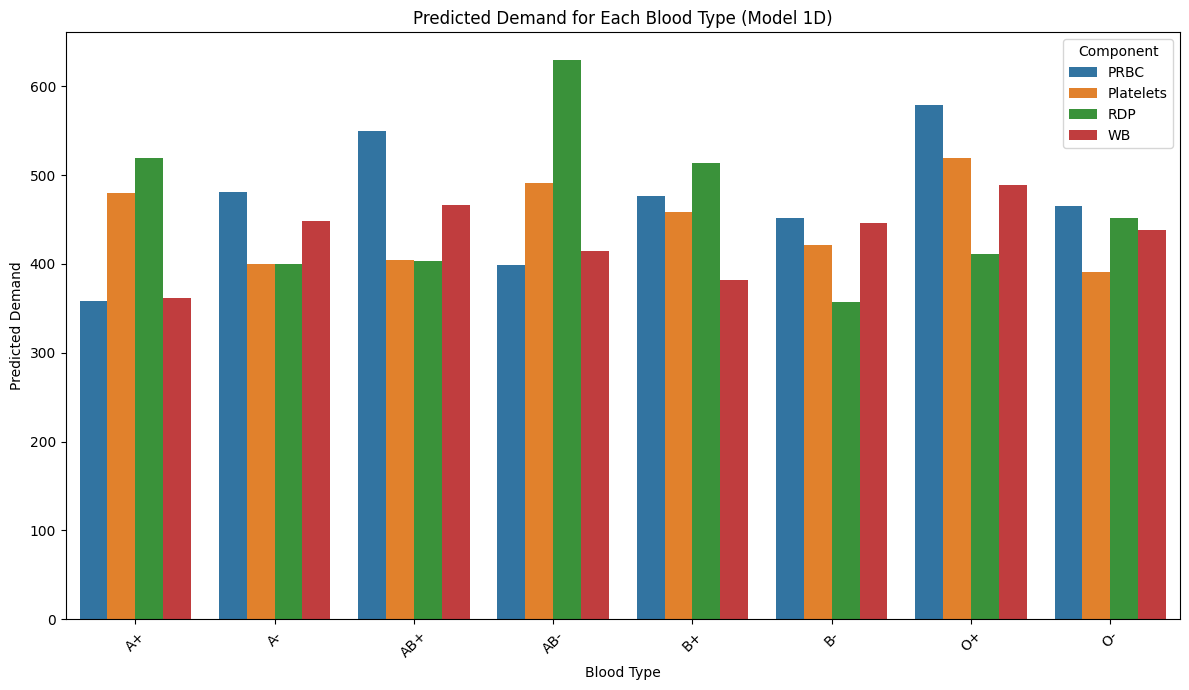

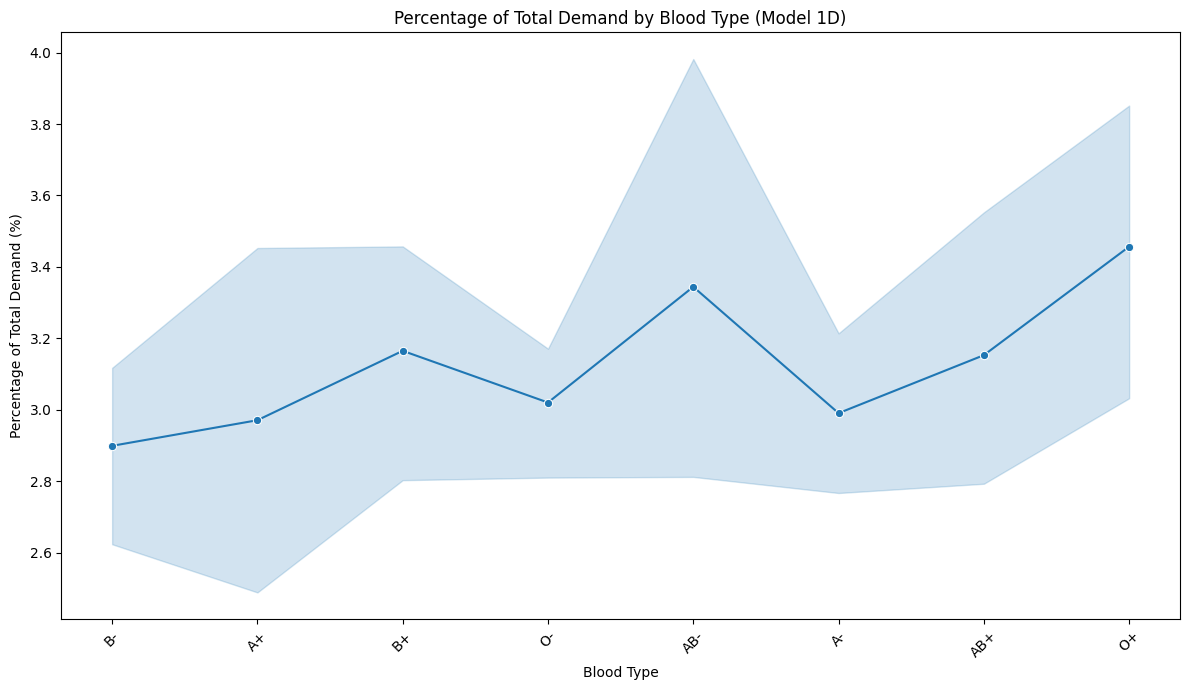

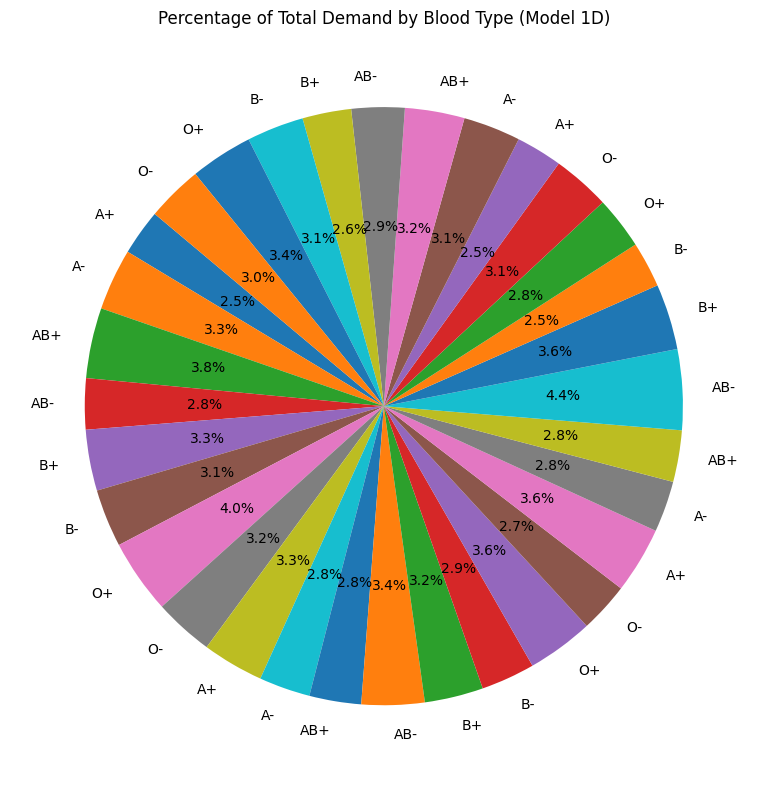

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the saved model for 'xgboost_model_1d.pkl'
with open('xgboost_model_1d.pkl', 'rb') as file:
    loaded_model_1d = pickle.load(file)

# Assuming df_final is prepared with the necessary features for the 'my_model_1d'
total_predicted_demand_all_types_1d = 0  # Initialize total predicted demand for all types for model_1d

predictions_1d = []  # Data structure to hold individual predictions for model_1d

# Iterate over each unique combination of blood component and type
for comp in df_final['Req_Comp'].unique():
    for blood_type in df_final['PBloodGroupTested'].unique():
        df_specific_1d = df_final[(df_final['Req_Comp'] == comp) & (df_final['PBloodGroupTested'] == blood_type)]
        
        if not df_specific_1d.empty:
            # Adjust feature names as per 'my_model_1d'
            X_predict_1d = df_specific_1d[['n_qty_n1d', 'ind_dow0', 'ind_dow1', 'ind_dow2', 'ind_dow3', 'ind_dow4', 'ind_dow5', 'ind_dow6',
                                           'n_qty_fem_n1d', 'n_qty_n7d', 'n_qty_n21d', 'ind_holiday']]
            predicted_demand_1d = loaded_model_1d.predict(X_predict_1d).sum()  # Total predicted demand
            
            total_predicted_demand_all_types_1d += predicted_demand_1d  # Update total predicted demand for model_1d
            
            predictions_1d.append({
                'Component': comp,
                'BloodType': blood_type,
                'PredictedDemand': predicted_demand_1d
            })

# Convert predictions for model_1d to a DataFrame for easier manipulation
predictions_df_1d = pd.DataFrame(predictions_1d)

# Calculate the percentage of total demand for each prediction for model_1d
predictions_df_1d['PercentageOfTotalDemand'] = (predictions_df_1d['PredictedDemand'] / total_predicted_demand_all_types_1d) * 100
for index, row in predictions_df_1d.iterrows():
    print(f"Component: {row['Component']}, Blood Type: {row['BloodType']}, Predicted Demand: {row['PredictedDemand']:.2f}, Percentage of Total Demand: {row['PercentageOfTotalDemand']:.2f}%")
# Visualization for model_1d
# Bar Graph for Predicted Demand for model_1d
plt.figure(figsize=(12, 7))
sns.barplot(data=predictions_df_1d, x='BloodType', y='PredictedDemand', hue='Component')
plt.title('Predicted Demand for Each Blood Type (Model 1D)')
plt.ylabel('Predicted Demand')
plt.xlabel('Blood Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line Graph for Percentage of Total Demand for model_1d
predictions_df_1d_sorted = predictions_df_1d.sort_values('PercentageOfTotalDemand')
plt.figure(figsize=(12, 7))
sns.lineplot(data=predictions_df_1d_sorted, x='BloodType', y='PercentageOfTotalDemand', marker='o')
plt.title('Percentage of Total Demand by Blood Type (Model 1D)')
plt.ylabel('Percentage of Total Demand (%)')
plt.xlabel('Blood Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie Chart for Percentage of Total Demand for model_1d
plt.figure(figsize=(8, 8))
plt.pie(predictions_df_1d['PercentageOfTotalDemand'], labels=predictions_df_1d['BloodType'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Total Demand by Blood Type (Model 1D)')
plt.tight_layout()
plt.show()



Model Predictions:
Component: PRBC, Blood Type: A+, Predicted Demand: 2588.14, Percentage of Total Demand: 2.55%
Component: PRBC, Blood Type: A-, Predicted Demand: 3304.57, Percentage of Total Demand: 3.26%
Component: PRBC, Blood Type: AB+, Predicted Demand: 3887.70, Percentage of Total Demand: 3.83%
Component: PRBC, Blood Type: AB-, Predicted Demand: 2847.91, Percentage of Total Demand: 2.81%
Component: PRBC, Blood Type: B+, Predicted Demand: 3370.30, Percentage of Total Demand: 3.32%
Component: PRBC, Blood Type: B-, Predicted Demand: 3245.23, Percentage of Total Demand: 3.20%
Component: PRBC, Blood Type: O+, Predicted Demand: 4078.73, Percentage of Total Demand: 4.02%
Component: PRBC, Blood Type: O-, Predicted Demand: 3302.24, Percentage of Total Demand: 3.26%
Component: Platelets, Blood Type: A+, Predicted Demand: 3297.54, Percentage of Total Demand: 3.25%
Component: Platelets, Blood Type: A-, Predicted Demand: 2808.16, Percentage of Total Demand: 2.77%
Component: Platelets, Blood 

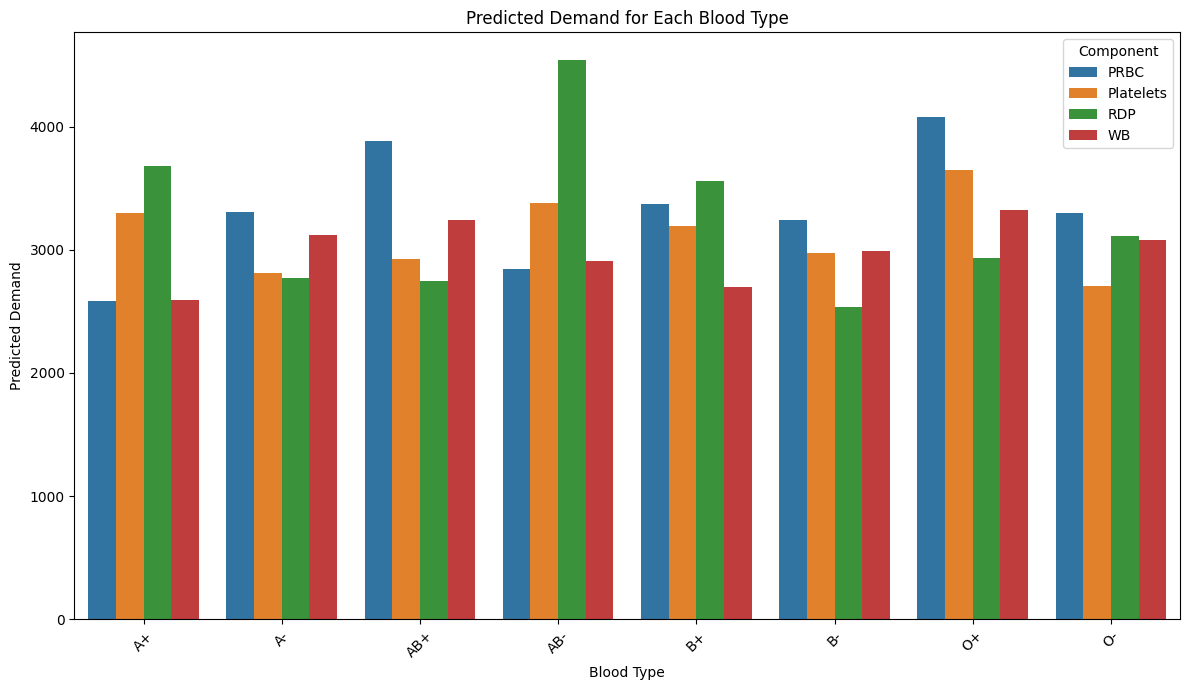

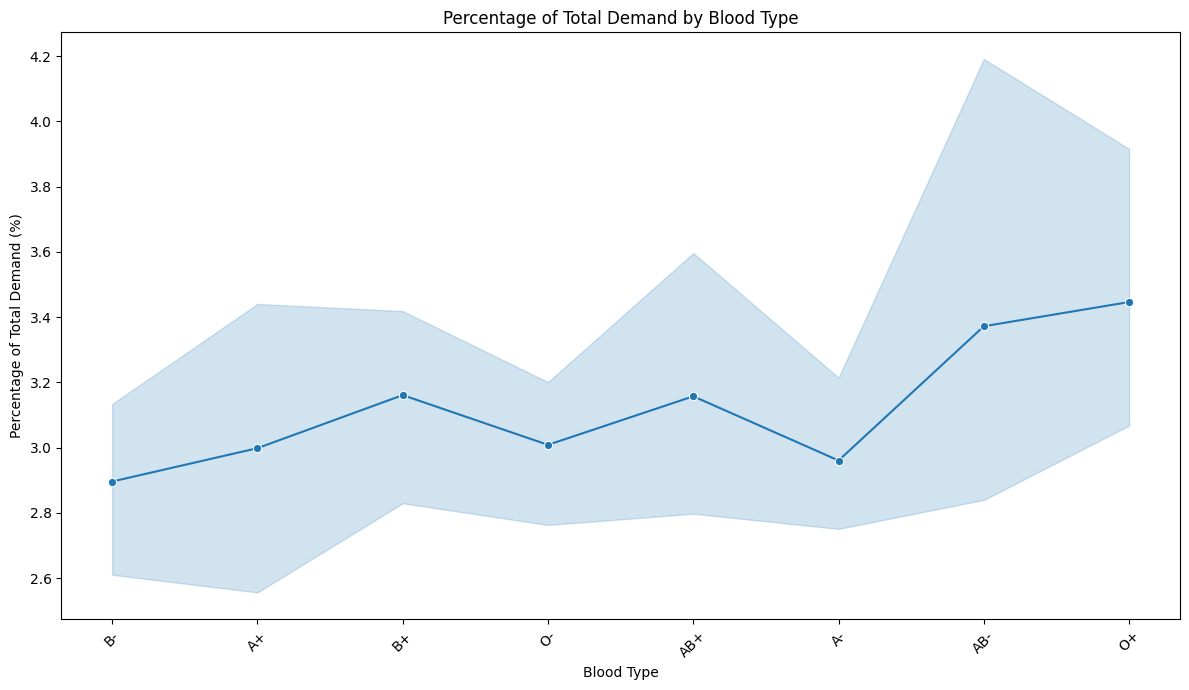

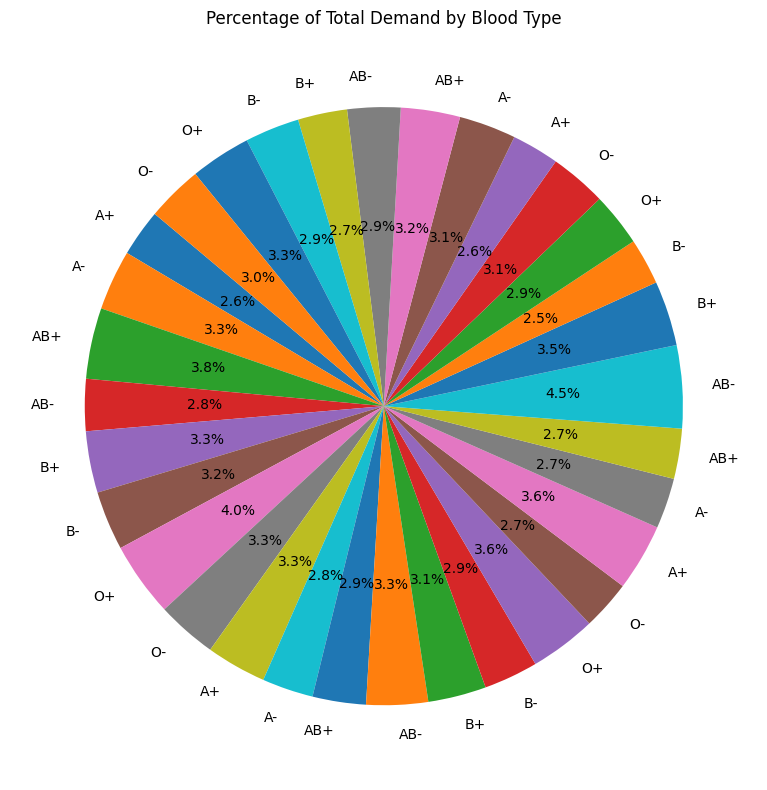

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the saved model
with open('model_7d.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Initialize total predicted demand for all types
total_predicted_demand_all_types = 0

# Data structure to hold individual predictions
predictions = []

# Iterate over each unique combination of blood component and type
for comp in df_final['Req_Comp'].unique():
    for blood_type in df_final['PBloodGroupTested'].unique():
        df_specific = df_final[(df_final['Req_Comp'] == comp) & (df_final['PBloodGroupTested'] == blood_type)]
        
        if not df_specific.empty:
            X_predict = df_specific[['n_qty_n1d', 'ind_dow0', 'ind_dow1', 'ind_dow2', 'ind_dow3', 'ind_dow4', 'ind_dow5', 'ind_dow6',
                                     'n_qty_n7d', 'n_qty_n21d', 'n_qty_fem_n1d', 'ind_holiday']]
            predicted_demand = loaded_model.predict(X_predict).sum()  # Total predicted demand
            
            total_predicted_demand_all_types += predicted_demand  # Update total predicted demand
            
            predictions.append({
                'Component': comp,
                'BloodType': blood_type,
                'PredictedDemand': predicted_demand
            })

# Convert predictions to a DataFrame for easier manipulation
predictions_df = pd.DataFrame(predictions)

# Calculate the percentage of total demand for each prediction
predictions_df['PercentageOfTotalDemand'] = (predictions_df['PredictedDemand'] / total_predicted_demand_all_types) * 100

# Printing the percentages for each blood type and component
print("\nModel Predictions:")
for index, row in predictions_df.iterrows():
    print(f"Component: {row['Component']}, Blood Type: {row['BloodType']}, Predicted Demand: {row['PredictedDemand']:.2f}, Percentage of Total Demand: {row['PercentageOfTotalDemand']:.2f}%")

# Visualization
# Bar Graph for Predicted Demand
plt.figure(figsize=(12, 7))
sns.barplot(data=predictions_df, x='BloodType', y='PredictedDemand', hue='Component')
plt.title('Predicted Demand for Each Blood Type')
plt.ylabel('Predicted Demand')
plt.xlabel('Blood Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line Graph for Percentage of Total Demand
predictions_df_sorted = predictions_df.sort_values('PercentageOfTotalDemand')
plt.figure(figsize=(12, 7))
sns.lineplot(data=predictions_df_sorted, x='BloodType', y='PercentageOfTotalDemand', marker='o')
plt.title('Percentage of Total Demand by Blood Type')
plt.ylabel('Percentage of Total Demand (%)')
plt.xlabel('Blood Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie Chart for Percentage of Total Demand
plt.figure(figsize=(8, 8))
plt.pie(predictions_df['PercentageOfTotalDemand'], labels=predictions_df['BloodType'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Total Demand by Blood Type')
plt.tight_layout()
plt.show()



21-Day Model Predictions:
Component: PRBC, Blood Type: A+, Predicted Demand: 7809.54, Percentage of Total Demand: 2.53%
Component: PRBC, Blood Type: A-, Predicted Demand: 10121.29, Percentage of Total Demand: 3.28%
Component: PRBC, Blood Type: AB+, Predicted Demand: 10654.99, Percentage of Total Demand: 3.45%
Component: PRBC, Blood Type: AB-, Predicted Demand: 8403.11, Percentage of Total Demand: 2.72%
Component: PRBC, Blood Type: B+, Predicted Demand: 9978.13, Percentage of Total Demand: 3.23%
Component: PRBC, Blood Type: B-, Predicted Demand: 9162.69, Percentage of Total Demand: 2.97%
Component: PRBC, Blood Type: O+, Predicted Demand: 12075.99, Percentage of Total Demand: 3.91%
Component: PRBC, Blood Type: O-, Predicted Demand: 9984.26, Percentage of Total Demand: 3.23%
Component: Platelets, Blood Type: A+, Predicted Demand: 9465.97, Percentage of Total Demand: 3.07%
Component: Platelets, Blood Type: A-, Predicted Demand: 8916.72, Percentage of Total Demand: 2.89%
Component: Platele

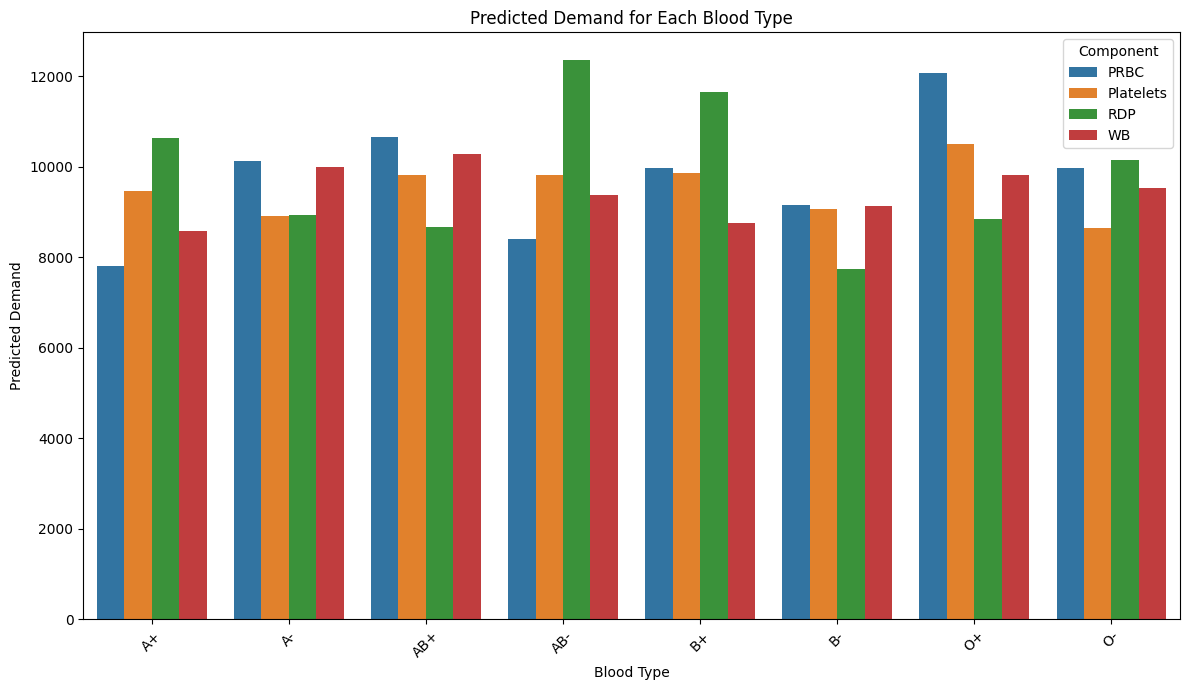

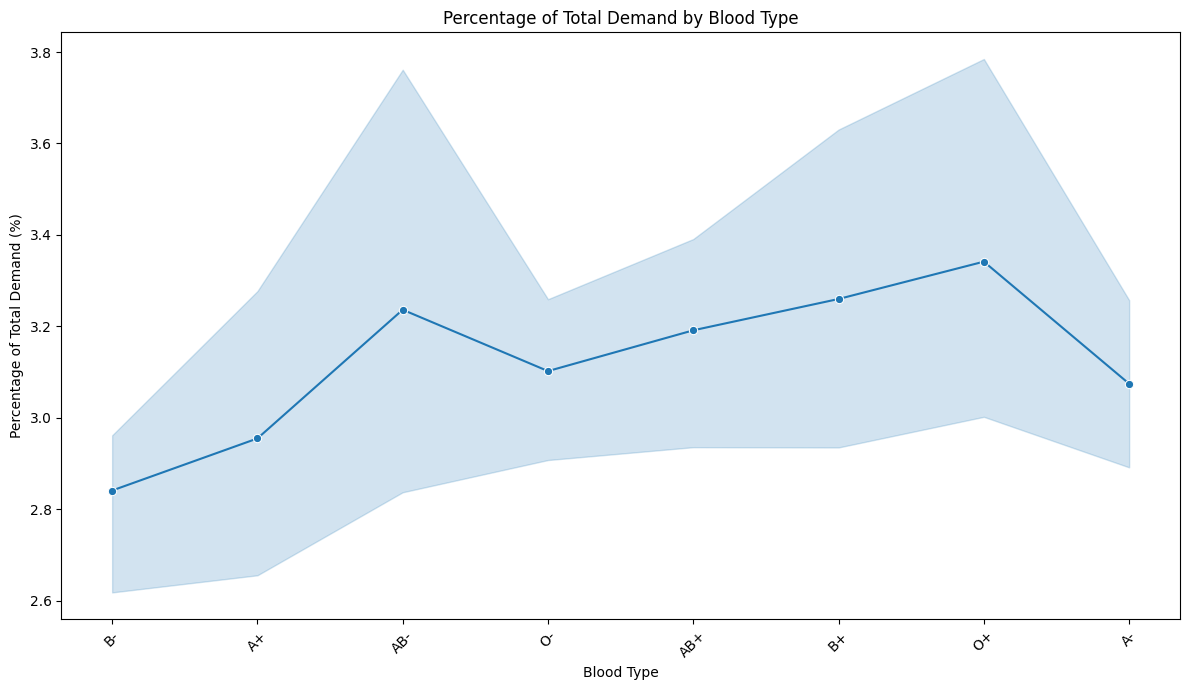

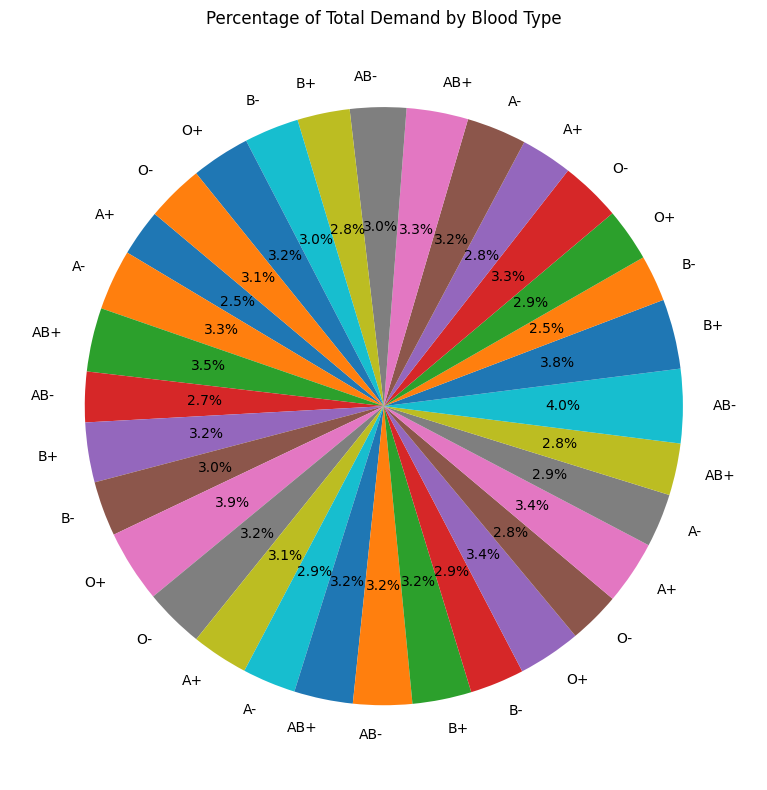

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load the saved model
with open('model_21d.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Assuming df_final is prepared with the necessary features
total_predicted_demand_all_types = 0  # Initialize total predicted demand for all types

predictions = []  # Data structure to hold individual predictions

# Iterate over each unique combination of blood component and type
for comp in df_final['Req_Comp'].unique():
    for blood_type in df_final['PBloodGroupTested'].unique():
        df_specific = df_final[(df_final['Req_Comp'] == comp) & (df_final['PBloodGroupTested'] == blood_type)]
        
        if not df_specific.empty:
            X_predict = df_specific[['rolling_avg_7d', 'rolling_avg_14d', 'month', 'day_of_week', 'ind_holiday']]
            predicted_demand = loaded_model.predict(X_predict).sum()  # Total predicted demand
            
            total_predicted_demand_all_types += predicted_demand  # Update total predicted demand
            
            predictions.append({
                'Component': comp,
                'BloodType': blood_type,
                'PredictedDemand': predicted_demand
            })

# Convert predictions to a DataFrame for easier manipulation
predictions_df = pd.DataFrame(predictions)  # Corrected variable name here

# Calculate the percentage of total demand for each prediction
predictions_df['PercentageOfTotalDemand'] = (predictions_df['PredictedDemand'] / total_predicted_demand_all_types) * 100

# Printing the percentages for each blood type and component
print("\n21-Day Model Predictions:")
for index, row in predictions_df.iterrows():
    print(f"Component: {row['Component']}, Blood Type: {row['BloodType']}, Predicted Demand: {row['PredictedDemand']:.2f}, Percentage of Total Demand: {row['PercentageOfTotalDemand']:.2f}%")

# Visualization
# Bar Graph for Predicted Demand
plt.figure(figsize=(12, 7))
sns.barplot(data=predictions_df, x='BloodType', y='PredictedDemand', hue='Component')
plt.title('Predicted Demand for Each Blood Type')
plt.ylabel('Predicted Demand')
plt.xlabel('Blood Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line Graph for Percentage of Total Demand
predictions_df_sorted = predictions_df.sort_values('PercentageOfTotalDemand')
plt.figure(figsize=(12, 7))
sns.lineplot(data=predictions_df_sorted, x='BloodType', y='PercentageOfTotalDemand', marker='o')
plt.title('Percentage of Total Demand by Blood Type')
plt.ylabel('Percentage of Total Demand (%)')
plt.xlabel('Blood Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie Chart for Percentage of Total Demand
plt.figure(figsize=(8, 8))
plt.pie(predictions_df['PercentageOfTotalDemand'], labels=predictions_df['BloodType'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Total Demand by Blood Type')
plt.tight_layout()
plt.show()
